In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
from inference.inference_utils import choose_model 
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [4]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)
datamodule.setup("test")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.test_dataloader()


loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [5]:
max_radius = fp_loader.max_radius

rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [6]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)


(526316, 526316)

In [7]:
from torch.nn.functional import cosine_similarity
import tqdm
model.setup_ranker()
model.ranker.data = model.ranker.data.to(model.device)

loading /root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_6_dim_16384_stacked_together/FP.pt


In [1]:
import matplotlib.pyplot as plt
import numpy as np

plot_order =['eHSQC, H NMR, and C NMR',
 'eHSQC and C NMR',
 'Standard HSQC, H NMR, and C NMR',
 'Standard HSQC and C NMR',
 'eHSQC and H NMR',
 'eHSQC Only',
 'Standard HSQC and H NMR',
 'Standard HSQC only',
 'C NMR and H NMR',
 'DeepSAT -- eHSQC',
    'DeepSAT -- Standard HSQC',
 'C NMR Only',
 'H NMR Only']

def plot_topk_accuracy(mean_rank_records, max_k=50, title="Structure Dereplication (Similarity = 1.0)"):
    """
    Plot Top-K accuracy curves for different models, sorted by performance in the legend.

    Args:
        mean_rank_records (dict): Dictionary mapping model names to lists of ranks.
        max_k (int): Maximum K value to plot.
        title (str): Plot title.
    """

    plt.figure(figsize=(10, 15))

    # Define a list of distinct colors
    # These colors are chosen for better visual separation than default matplotlib colors.
    colors = [
        '#E6194B', "#4BDD5E", "#FFDD00", "#6F8AEE", '#F58231',
        '#911EB4', '#46F0F0', '#F032E6', 
        '#008080',  "#A7671F", "#0202FF", '#808080',  '#000000',
    ]

    # Calculate Top-K accuracy for each model and store for sorting
    model_performance = {}
    for model_name, ranks in mean_rank_records.items():
        topk_accuracies = []
        for k in range(1, max_k + 1):
            correct_count = sum(1 for rank in ranks if rank < k)
            accuracy = (correct_count / len(ranks)) * 100
            topk_accuracies.append(accuracy)
        # Store the calculated accuracies and the model name
        model_performance[model_name] = topk_accuracies

    # Sort models by their final accuracy (at max_k) in descending order
    # sorted_models = sorted(model_performance.items(), key=lambda item: item[1][-1], reverse=True)

    # for i, (model_name, topk_accuracies) in enumerate(sorted_models):
    for i, model_name in enumerate(plot_order):
        if model_name not in model_performance:
            # print(f"Warning: {model_name} not found in model_performance. Skipping.")
            continue
        topk_accuracies = model_performance[model_name]
        x_values = range(1, max_k + 1)
        plt.step(x_values, topk_accuracies,
                 label=model_name,
                 color=colors[i % len(colors)],
                 linewidth=1.3,
                 where='post')

    # Customize the plot
    plt.xlabel('Top-K Retrieved Compounds', fontsize=15)
    plt.ylabel('% of correct dereplication (containing the ground truth compound)', fontsize=15)
    plt.title(title, fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=13, loc='center right')

    # Set axis limits
    plt.xlim(0, max_k)
    plt.ylim(0, 100)

    # Add more tick marks on x-axis
    plt.xticks(range(0, max_k + 1, 5))
    plt.yticks(range(0, 101, 10))

    plt.tight_layout()
    plt.show()

In [9]:
# Order: [loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR]

old_loader_idx_to_name_mapping = {
    0: "All Inputs",
    1: "HSQC and H NMR",
    2: "HSQC and C NMR",
    3: "HSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC (Non-Multiplicity-Edited)",
}


loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC only",
    8: "Standard HSQC, H NMR, and C NMR",
    9: "Standard HSQC and H NMR",
    10: "Standard HSQC and C NMR",
    
    
}

In [10]:
old_name_to_loader_idx_mapping = {v: k for k, v in old_loader_idx_to_name_mapping.items()}

In [5]:
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_with_mw.pkl", 'rb') as file:
    pre_mean_rank_records = pickle.load(file)

with open(save_dir + "topk_without_mw.pkl", 'rb') as file:
    pre_mean_rank_records_no_MW = pickle.load(file)

# # load 
import pickle
save_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"
with open(save_dir + "topk_with_mw_11_input_types.pkl", 'rb') as file:
    mean_rank_records = pickle.load(file)
with open(save_dir + "topk_without_mw_11_input_types.pkl", 'rb') as file:
    mean_rank_records_no_MW = pickle.load(file)

In [12]:
mean_rank_records.keys()

dict_keys(['eHSQC, H NMR, and C NMR', 'eHSQC and H NMR', 'eHSQC and C NMR', 'eHSQC Only', 'C NMR and H NMR', 'H NMR Only', 'C NMR Only', 'Standard HSQC only', 'Standard HSQC, H NMR, and C NMR', 'Standard HSQC and H NMR', 'Standard HSQC and C NMR'])

In [13]:
from collections import defaultdict

## with MW
mean_rank_records = defaultdict(list)

for i in range(11):
    if i<7:
        # loading from old records
        mean_rank_records[loader_idx_to_name_mapping[i]] = pre_mean_rank_records[old_loader_idx_to_name_mapping[i]]
        continue
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records[loader_idx_to_name_mapping[i]].append(result['mean_rank'])

0it [00:00, ?it/s]

4056it [01:52, 36.05it/s]
4056it [01:54, 35.42it/s]
4056it [01:59, 34.00it/s]
4056it [01:59, 33.83it/s]


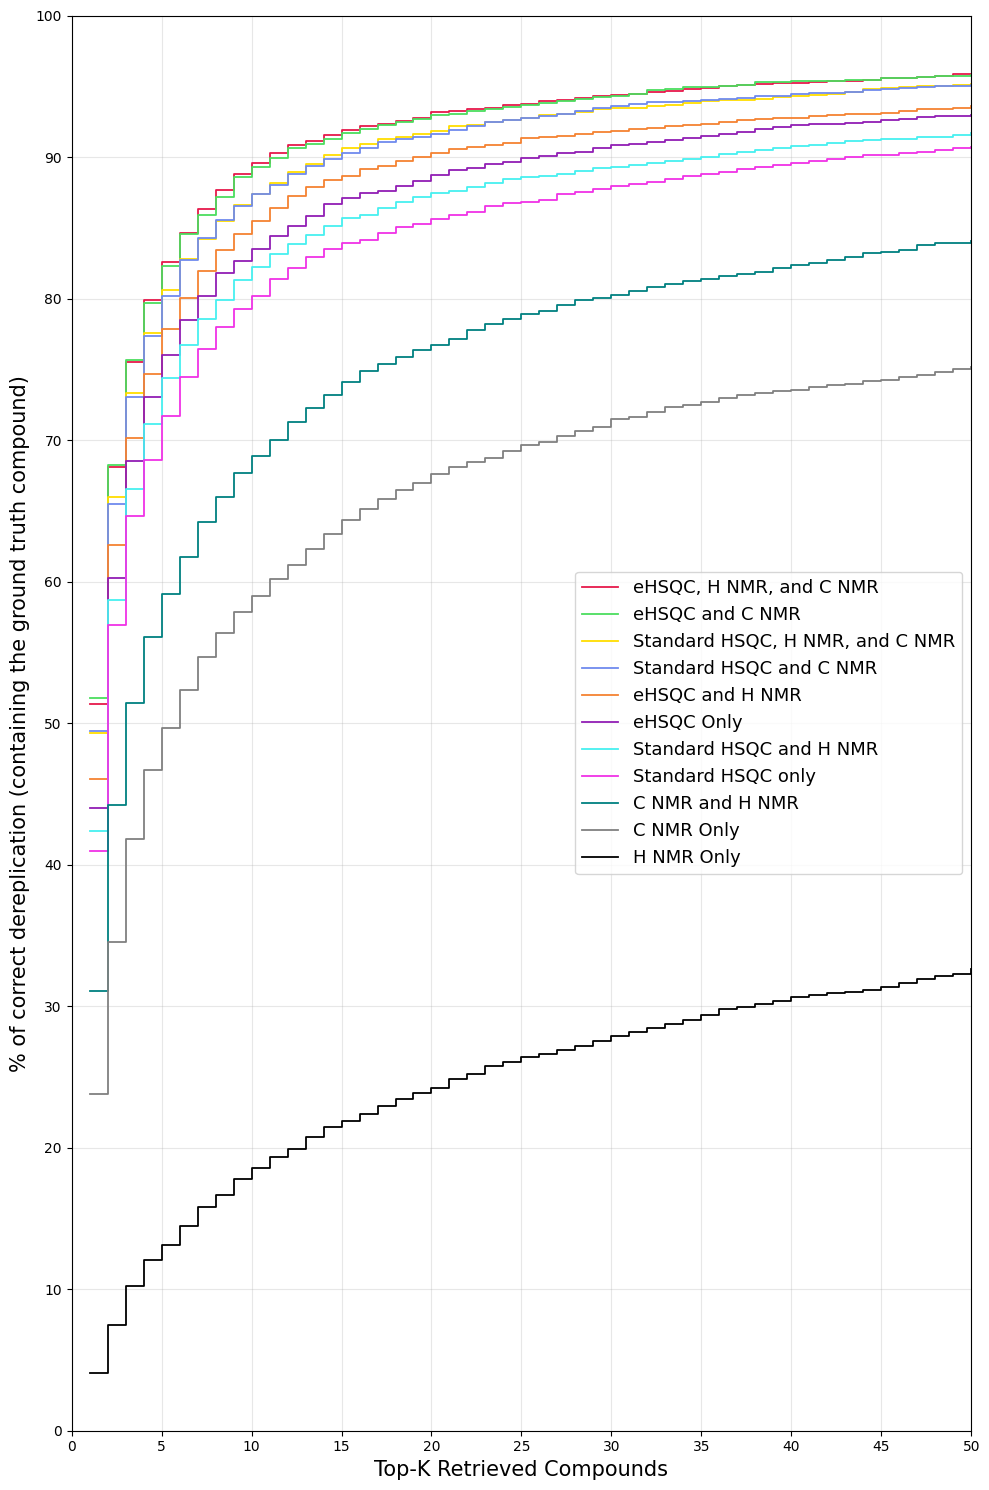

In [14]:
plot_topk_accuracy(mean_rank_records, title="") #Structure Dereplication (using molecular weight)

In [15]:
for k,v in mean_rank_records.items():
    print(k, np.mean(v))

eHSQC, H NMR, and C NMR 176.1429980276134
eHSQC and H NMR 307.05029585798815
eHSQC and C NMR 183.9940828402367
eHSQC Only 261.038708086785
C NMR and H NMR 939.3971893491124
H NMR Only 12041.439102564103
C NMR Only 3053.9336785009864
Standard HSQC only 514.1945266272189
Standard HSQC, H NMR, and C NMR 270.5557199211045
Standard HSQC and H NMR 513.9817554240631
Standard HSQC and C NMR 281.79092702169623


In [16]:

        
        
        
        

## without  MW
mean_rank_records_no_MW = defaultdict(list)
for i in range(11):
    
    if i<7:
        # loading from old records
        mean_rank_records_no_MW[loader_idx_to_name_mapping[i]] = pre_mean_rank_records_no_MW[old_loader_idx_to_name_mapping[i]]
        continue
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C pNMR
        loader_idx = 2
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        # remove mw
        batch[0] = batch[0][:, :-1]
        # remove mw
        batch[2] = batch[2][:, :-1]
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records_no_MW[loader_idx_to_name_mapping[i]].append(result['mean_rank'])        


0it [00:00, ?it/s]

4056it [01:57, 34.66it/s]
4056it [01:59, 34.04it/s]
4056it [01:51, 36.50it/s]
4056it [01:57, 34.62it/s]


In [17]:
for k,v in mean_rank_records_no_MW.items():
    print(k, np.mean(v))

eHSQC, H NMR, and C NMR 215.18737672583828
eHSQC and H NMR 437.6301775147929
eHSQC and C NMR 199.14324457593688
eHSQC Only 321.1895956607495
C NMR and H NMR 1142.9055719921105
H NMR Only 14465.192061143984
C NMR Only 3567.754191321499
Standard HSQC only 668.9980276134122
Standard HSQC, H NMR, and C NMR 334.611932938856
Standard HSQC and H NMR 667.4575936883629
Standard HSQC and C NMR 334.9045857988166


In [2]:
# cobining DeepSAT result into mean_rank_records_no_MW
# 
import pickle
import tqdm
from collections import defaultdict
mean_rank_records_no_MW = defaultdict(list)
shared_testset_pkl = "shared_testset_path_for_deepsat_hsqc_available" 
with open(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/{shared_testset_pkl}.pkl", "rb") as f:
    shared_testset_path = pickle.load(f)
    
    
deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set.pkl"
with open(deepsat_infer_results_save_path, "rb") as f:
    deepsat_infer_results = pickle.load(f)
    
mean_rank_records_no_MW.update({"DeepSAT -- eHSQC": []})  
for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
    result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
    for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
        if ( ground_smiles == filtered_smiles):
            mean_rank_records_no_MW["DeepSAT -- eHSQC"].append(i)
            break
    else:
        mean_rank_records_no_MW["DeepSAT -- eHSQC"].append(50)
        
        
        
deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set_standard_HSQC.pkl"
with open(deepsat_infer_results_save_path, "rb") as f:
    deepsat_infer_results = pickle.load(f)
    
mean_rank_records_no_MW.update({"DeepSAT -- Standard HSQC": []})  
for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
    result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
    for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
        if ( ground_smiles == filtered_smiles):
            mean_rank_records_no_MW["DeepSAT -- Standard HSQC"].append(i)
            break
    else:
        mean_rank_records_no_MW["DeepSAT -- Standard HSQC"].append(50)

100%|██████████| 341/341 [00:00<00:00, 408761.84it/s]


In [4]:
for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
    print(ground_smiles)
    break

  0%|          | 0/341 [00:00<?, ?it/s]

CC(C#CC1=C(C)CC(O)CC1(C)C)=CC=CC(C)=CC=CC=C(C)C=CC=C(C)C#CC1=C(C)CC(O)CC1(C)C


In [3]:
import numpy as np
np.sum(np.array(mean_rank_records_no_MW["DeepSAT -- eHSQC"]) == 0) / 341

np.float64(0.3489736070381232)

In [19]:
# import pickle
# save_dir_ranking = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_inference_results/ranking_result/"

# load_path = save_dir_ranking + "ranking.pkl"

# with open(load_path, 'rb') as file:
#     loaded = pickle.load(file)
# mean_rank_records_no_MW["HSQC, by DeepSAT"] = loaded



In [7]:
mean_rank_records_no_MW.pop("DeepSAT -- eHSQC")
mean_rank_records_no_MW.pop("DeepSAT -- Standard HSQC")

[0,
 19,
 11,
 2,
 0,
 11,
 3,
 1,
 50,
 0,
 50,
 50,
 0,
 15,
 0,
 48,
 50,
 9,
 8,
 50,
 8,
 50,
 1,
 50,
 30,
 0,
 0,
 50,
 1,
 1,
 50,
 0,
 2,
 1,
 13,
 2,
 50,
 1,
 5,
 11,
 3,
 8,
 50,
 50,
 0,
 3,
 0,
 1,
 0,
 50,
 0,
 50,
 50,
 0,
 26,
 10,
 1,
 0,
 50,
 50,
 50,
 0,
 0,
 28,
 50,
 3,
 5,
 0,
 2,
 3,
 3,
 4,
 16,
 50,
 2,
 50,
 50,
 50,
 0,
 0,
 16,
 1,
 15,
 1,
 16,
 0,
 0,
 1,
 6,
 0,
 0,
 11,
 0,
 1,
 11,
 11,
 3,
 0,
 0,
 0,
 50,
 0,
 50,
 5,
 0,
 50,
 3,
 50,
 0,
 50,
 1,
 3,
 2,
 0,
 0,
 13,
 1,
 0,
 50,
 22,
 0,
 50,
 50,
 11,
 1,
 0,
 50,
 0,
 22,
 0,
 4,
 32,
 0,
 50,
 2,
 2,
 2,
 3,
 50,
 50,
 50,
 3,
 3,
 0,
 50,
 0,
 0,
 50,
 50,
 0,
 0,
 0,
 4,
 50,
 2,
 3,
 0,
 50,
 1,
 50,
 50,
 13,
 6,
 0,
 0,
 50,
 0,
 39,
 1,
 0,
 50,
 0,
 1,
 14,
 21,
 8,
 0,
 1,
 0,
 7,
 0,
 0,
 3,
 0,
 4,
 0,
 50,
 1,
 4,
 50,
 2,
 50,
 22,
 6,
 3,
 50,
 50,
 0,
 33,
 1,
 0,
 50,
 3,
 4,
 0,
 50,
 14,
 23,
 6,
 11,
 0,
 1,
 1,
 31,
 1,
 1,
 50,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 3

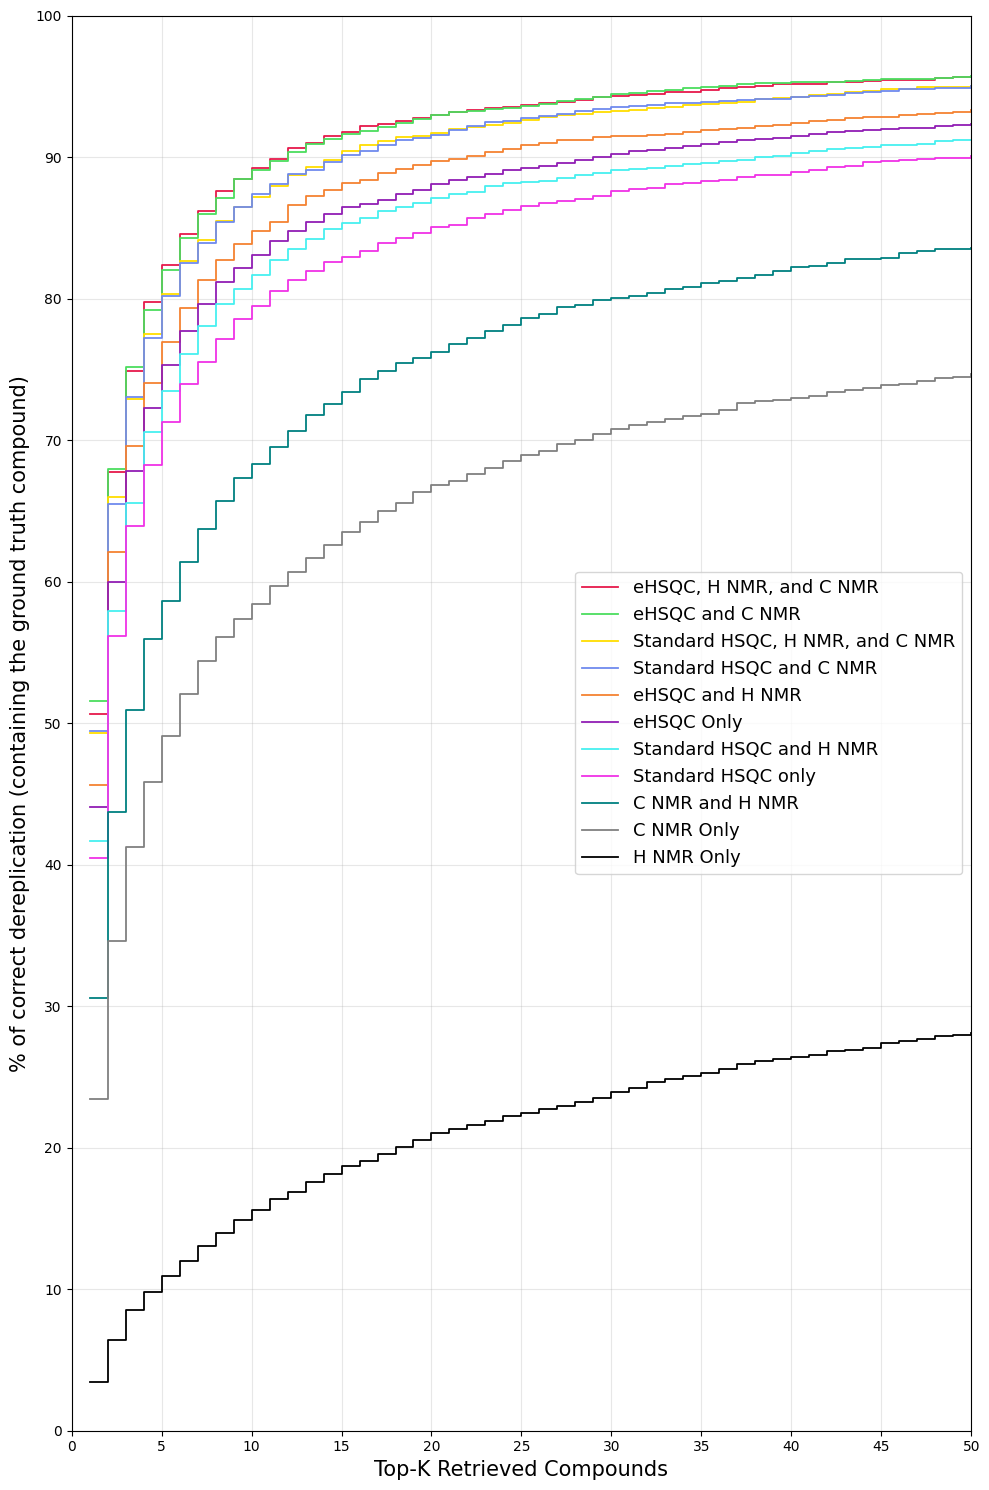

In [8]:
plot_topk_accuracy(mean_rank_records_no_MW, title="") #Structure Dereplication (not using molecular weight)

In [21]:

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_with_mw_11_input_types.pkl", 'wb') as file:
    pickle.dump(mean_rank_records, file)
with open(save_dir + "topk_without_mw_11_input_types.pkl", 'wb') as file:
    pickle.dump(mean_rank_records_no_MW, file)

